# Install and Import Libraries

In [81]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [83]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# ML algorithms
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

import catboost as cb

# Warnings off
import warnings
warnings.filterwarnings('ignore')

 # Load and Explore the Data

In [86]:
# Load dataset
df = pd.read_csv("Liver_dataset.csv")

In [87]:
# Preview
df.head(10)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1
5,26,Female,0.9,0.2,154,16,12,7.0,3.5,1.00,1
6,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.10,1
7,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.20,2
8,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.00,1
9,57,Male,0.6,0.1,210,51,59,5.9,2.7,0.80,1


# Basic Info & Descriptive Stats

In [89]:
# General info
print(" Dataset Overview:")
df.info()

# Descriptive stats
print("\n Descriptive Statistics:")
print(df.describe(include='all'))

# Check for nulls
print("\n🕳 Missing Values:")
print(df.isnull().sum())


 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         1056 non-null   int64  
 1   Gender                      1056 non-null   object 
 2   Total_Bilirubin             1056 non-null   float64
 3   Direct_Bilirubin            1056 non-null   float64
 4   Alkaline_Phosphotase        1056 non-null   int64  
 5   Alamine_Aminotransferase    1056 non-null   int64  
 6   Aspartate_Aminotransferase  1056 non-null   int64  
 7   Total_Protiens              1056 non-null   float64
 8   Albumin                     1056 non-null   float64
 9   Albumin_and_Globulin_Ratio  1048 non-null   float64
 10  Dataset                     1056 non-null   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 90.9+ KB

 Descriptive Statistics:
                Age Gender  Total_Bilirubin 

# Preprocessing the  Data

In [91]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Encode Gender
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])  # Male: 1, Female: 0

# Adjust target variable to binary: 1 = Disease, 0 = No Disease
df['Dataset'] = df['Dataset'].apply(lambda x: 1 if x == 1 else 0)

# Features and labels
X = df.drop('Dataset', axis=1)
y = df['Dataset']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)


In [92]:
# Rename Dataset column to Target for clarity
df.rename(columns={'Dataset': 'Target'}, inplace=True)



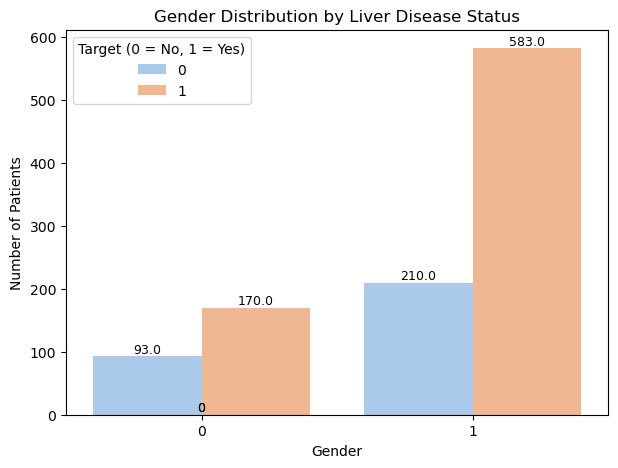

In [93]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='Gender', hue='Target', data=df, palette='pastel')
plt.title('Gender Distribution by Liver Disease Status')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.legend(title='Target (0 = No, 1 = Yes)')
plt.show()


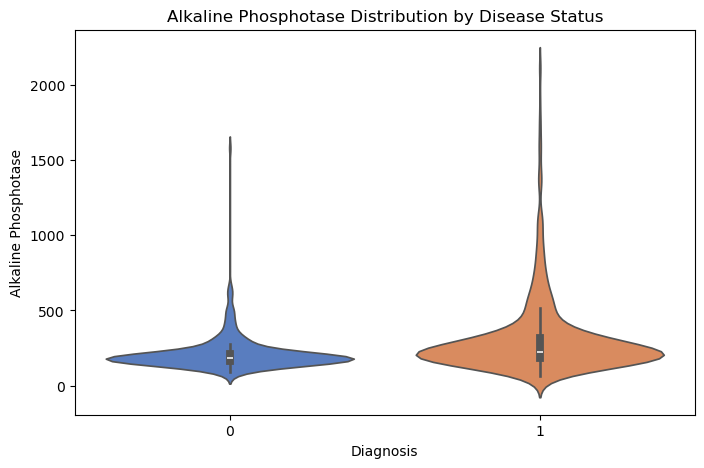

In [94]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='Target', y='Alkaline_Phosphotase', data=df, palette='muted')
plt.title('Alkaline Phosphotase Distribution by Disease Status')
plt.xlabel('Diagnosis')
plt.ylabel('Alkaline Phosphotase')
plt.show()


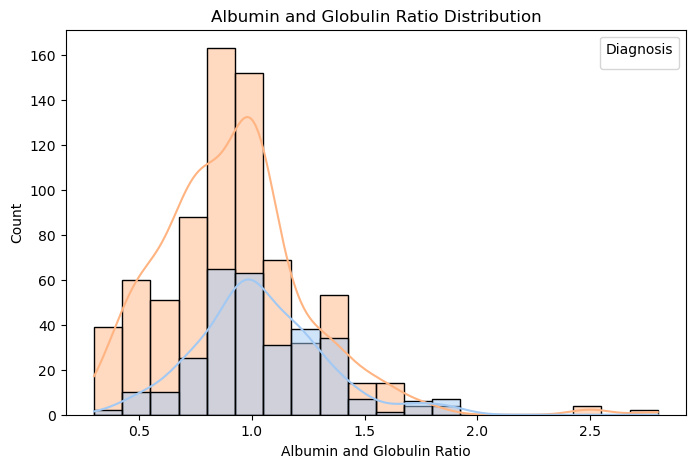

In [95]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Albumin_and_Globulin_Ratio', hue='Target', bins=20, kde=True, palette='pastel')
plt.title('Albumin and Globulin Ratio Distribution')
plt.xlabel('Albumin and Globulin Ratio')
plt.ylabel('Count')
plt.legend(title='Diagnosis')
plt.show()


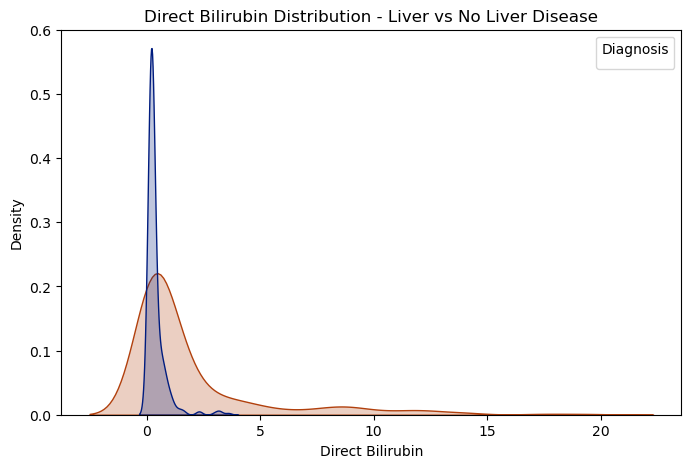

In [96]:
# Shows whether Direct Bilirubin levels are generally higher in patients with liver disease
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='Direct_Bilirubin', hue='Target', fill=True, palette='dark')
plt.title('Direct Bilirubin Distribution - Liver vs No Liver Disease')
plt.xlabel('Direct Bilirubin')
plt.ylabel('Density')
plt.legend(title='Diagnosis')
plt.show()


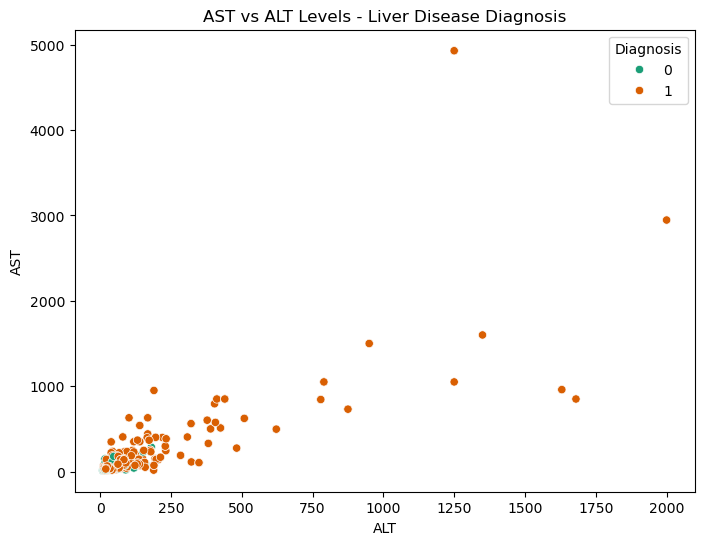

In [97]:
#Aspartate Aminotransferase (AST) vs ALT (Scatter Plot)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Alamine_Aminotransferase', y='Aspartate_Aminotransferase', hue='Target', palette='Dark2')
plt.title('AST vs ALT Levels - Liver Disease Diagnosis')
plt.xlabel('ALT')
plt.ylabel('AST')
plt.legend(title='Diagnosis')
plt.show()


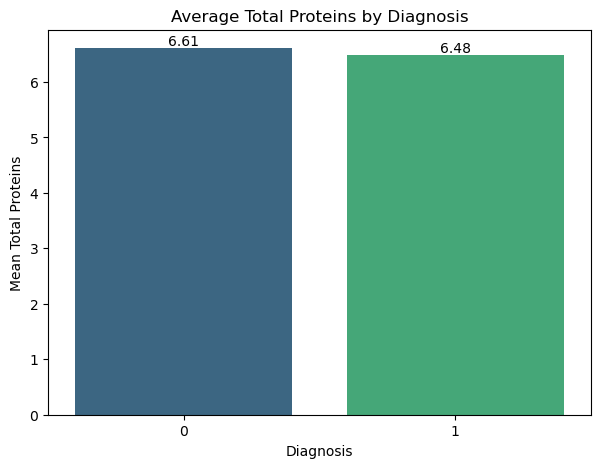

In [98]:
# Total Proteins by Diagnosis (Bar Plot with Means)
protein_means = df.groupby('Target')['Total_Protiens'].mean().reset_index()

plt.figure(figsize=(7, 5))
sns.barplot(data=protein_means, x='Target', y='Total_Protiens', palette='viridis')
plt.title('Average Total Proteins by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Mean Total Proteins')
for index, row in protein_means.iterrows():
    plt.text(index, row.Total_Protiens + 0.05, round(row.Total_Protiens, 2), ha='center')
plt.show()


In [99]:
df.fillna(df.mean(), inplace=True)

#  Encode Categorical Variables (Gender)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})


In [100]:
# Split Data into Features (X) and Target (y)
X = df.drop(['Target'], axis=1)
y = df['Target']

#  Split into Training and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [101]:
#  Scale the Data (standardize the features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define and Train the Models

In [103]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

In [104]:
# Create an imputer to fill missing values
imputer = SimpleImputer(strategy='mean')  # You can change the strategy to 'median' or 'most_frequent'

# Initialize the models
gb_model = make_pipeline(imputer, GradientBoostingClassifier())
lgb_model = make_pipeline(imputer, lgb.LGBMClassifier())
cb_model = make_pipeline(imputer, CatBoostClassifier(silent=True))

# Train the models
gb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cb_model.fit(X_train, y_train)

# Make predictions
gb_pred = gb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)
cb_pred = cb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 605, number of negative: 239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 844, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.716825 -> initscore=0.928765
[LightGBM] [Info] Start training from score 0.928765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [105]:
# Calculate accuracy scores for each model
gb_accuracy = accuracy_score(y_test, gb_pred)
lgb_accuracy = accuracy_score(y_test, lgb_pred)
cb_accuracy = accuracy_score(y_test, cb_pred)

# Print the accuracy scores
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")
print(f"CatBoost Accuracy: {cb_accuracy:.4f}")

# Classification Reports for each model
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, gb_pred))
print("\nLightGBM Classification Report:\n", classification_report(y_test, lgb_pred))
print("\nCatBoost Classification Report:\n", classification_report(y_test, cb_pred))

Gradient Boosting Accuracy: 0.8491
LightGBM Accuracy: 0.9670
CatBoost Accuracy: 0.9151

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.58      0.70        64
           1       0.84      0.97      0.90       148

    accuracy                           0.85       212
   macro avg       0.86      0.77      0.80       212
weighted avg       0.85      0.85      0.84       212


LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94        64
           1       0.97      0.98      0.98       148

    accuracy                           0.97       212
   macro avg       0.96      0.96      0.96       212
weighted avg       0.97      0.97      0.97       212


CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85        64
           1       0.91      0.97      

In [106]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, accuracy_score
from tabulate import tabulate
import numpy as np

# Calculate the metrics for each model
metrics = {
    "Model": ["Gradient Boosting", "LightGBM", "CatBoost"],
    "Accuracy": [
        accuracy_score(y_test, gb_pred),
        accuracy_score(y_test, lgb_pred),
        accuracy_score(y_test, cb_pred),
    ],
    "Precision": [
        precision_score(y_test, gb_pred),
        precision_score(y_test, lgb_pred),
        precision_score(y_test, cb_pred),
    ],
    "Recall": [
        recall_score(y_test, gb_pred),
        recall_score(y_test, lgb_pred),
        recall_score(y_test, cb_pred),
    ],
    "F1-Score": [
        f1_score(y_test, gb_pred),
        f1_score(y_test, lgb_pred),
        f1_score(y_test, cb_pred),
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, cb_model.predict_proba(X_test)[:, 1]),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, gb_pred)),
        np.sqrt(mean_squared_error(y_test, lgb_pred)),
        np.sqrt(mean_squared_error(y_test, cb_pred)),
    ]
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Print the metrics in a readable table format using tabulate
print(tabulate(metrics_df, headers="keys", tablefmt="grid", showindex=False))


+-------------------+------------+-------------+----------+------------+-----------+----------+
| Model             |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |     RMSE |
+===================+============+=============+==========+============+===========+==========+
| Gradient Boosting |   0.849057 |    0.841176 | 0.966216 |   0.899371 |  0.940456 | 0.388514 |
+-------------------+------------+-------------+----------+------------+-----------+----------+
| LightGBM          |   0.966981 |    0.973154 | 0.97973  |   0.976431 |  0.983953 | 0.181711 |
+-------------------+------------+-------------+----------+------------+-----------+----------+
| CatBoost          |   0.915094 |    0.911392 | 0.972973 |   0.941176 |  0.969911 | 0.291386 |
+-------------------+------------+-------------+----------+------------+-----------+----------+


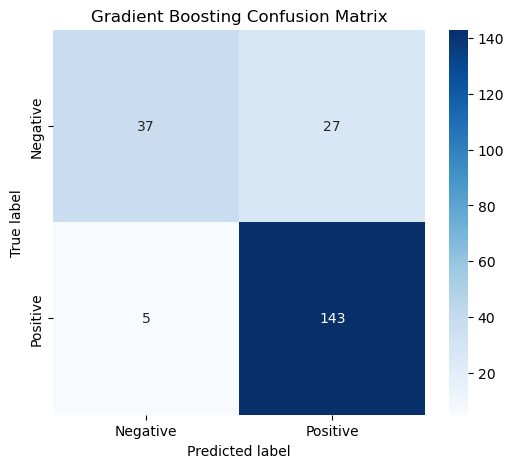

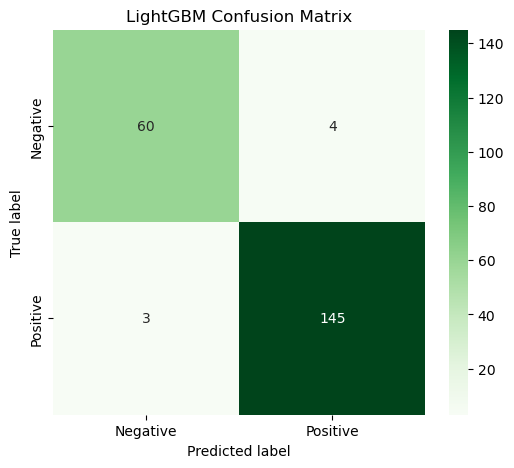

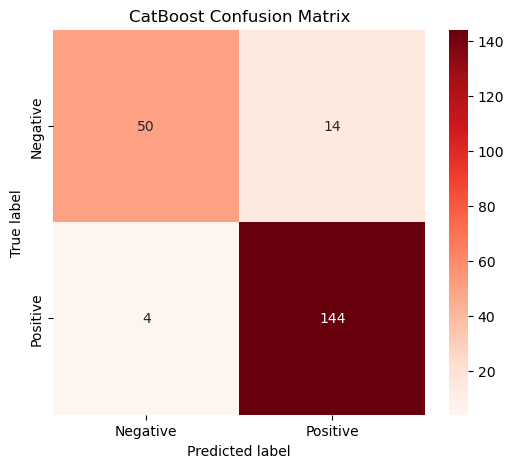

In [107]:
# Assuming models are trained and predictions are made
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix with different colors for each model
def plot_confusion_matrix(y_true, y_pred, model_name, color_map):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_map, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot Confusion Matrices for each model with different colors
plot_confusion_matrix(y_test, gb_pred, 'Gradient Boosting', 'Blues')
plot_confusion_matrix(y_test, lgb_pred, 'LightGBM', 'Greens')
plot_confusion_matrix(y_test, cb_pred, 'CatBoost', 'Reds')


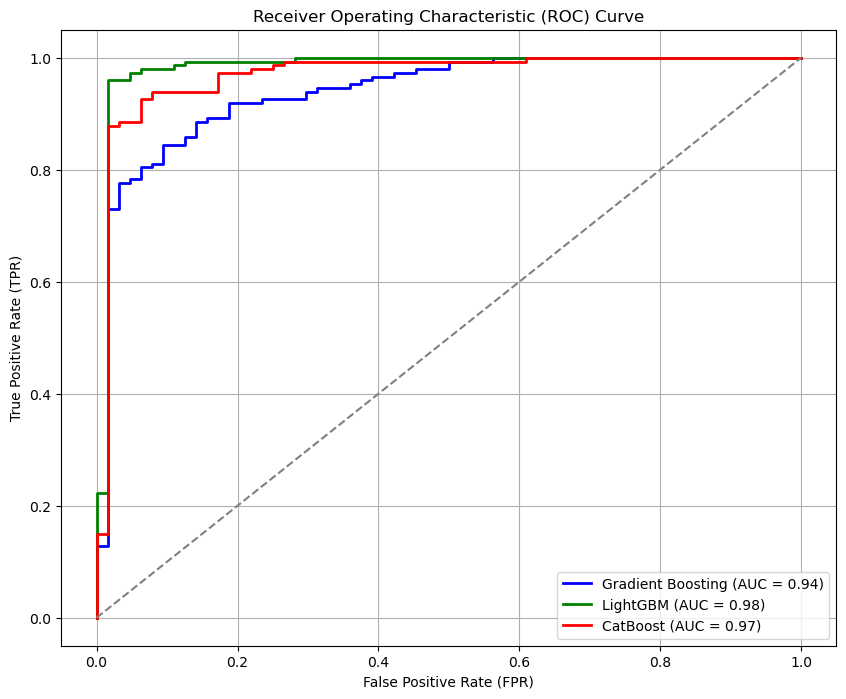

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to plot ROC curve for each model
def plot_roc_curve(y_true, y_prob, model_name, color):
    # Get the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)  # Calculate the area under the curve
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Assuming you have already trained the models and got their probability predictions
# For Gradient Boosting, LightGBM, and CatBoost models, use predict_proba to get probabilities
# X_test is your test set, and y_test is the true labels for evaluation

# Plot ROC curve for each model
plt.figure(figsize=(10, 8))

# Gradient Boosting ROC Curve
plot_roc_curve(y_test, gb_model.predict_proba(X_test)[:, 1], 'Gradient Boosting', 'blue')

# LightGBM ROC Curve
plot_roc_curve(y_test, lgb_model.predict_proba(X_test)[:, 1], 'LightGBM', 'green')

# CatBoost ROC Curve
plot_roc_curve(y_test, cb_model.predict_proba(X_test)[:, 1], 'CatBoost', 'red')

# Plot Random Classifier (Diagonal Line) for reference
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()
